In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from yahoofinancials import YahooFinancials as yf
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
def get_stock_data(tickers, start_date, end_date, freq='daily'): 
    ticker_not_found=[]
    for ticker in tickers:
        yf_engine = yf(ticker)
        price = yf_engine.get_historical_price_data(start_date,end_date,freq)
        try:
            ticker_data = pd.DataFrame(price[ticker]['prices'])
            ticker_data = ticker_data.drop('date', axis=1)
        except:
            ticker_not_found.append(ticker)
            continue
            
    return ticker_data, ticker_not_found

In [3]:
ticker = ['PLTR']
start_date = '2020-09-30'
end_date = '2021-10-01'

df, ticker_not_found = get_stock_data(ticker, start_date, end_date)

df.tail()

,high,low,open,close,volume,adjclose,formatted_date
70,26.600000,24.309999,24.610001,25.930000,32609000,25.930000,2021-01-11
71,26.420000,25.510000,26.340000,26.180000,26995000,26.180000,2021-01-12
72,27.430000,25.129999,25.709999,25.500000,51216600,25.500000,2021-01-13
73,25.620001,24.370001,25.450001,24.920000,32908000,24.920000,2021-01-14
74,28.000000,25.459999,26.260000,25.639999,92037000,25.639999,2021-01-15


In [4]:
def get_clean_data (df, start_date, end_date):
    
    features = df.copy()
    features = features.drop(['formatted_date'], axis=1)
    features['volume'] = features['volume'].shift(1)
    features['SMA'] = features['adjclose'].rolling(window=60).mean().shift(1)
    features['Std'] = features['adjclose'].rolling(window=60).std().shift(1)
    features['Band_1'] = features['SMA'] - features['Std']
    features['Band_2'] = features['SMA'] + features['Std']
    features['ON_returns'] = features['close'] - features['open'].shift(-1)
    features['ON_returns'] = features['ON_returns'].shift(1)
    features['ON_returns_signal'] = np.where(features['ON_returns']<0, 'up', 'down')
    features['dist_from_mean'] = features['adjclose'].shift(1) - features['SMA']
    #Obtaining Vix Data and combining with existing features of stock
    ticker = ['^VIX']
    start_date = start_date
    end_date = end_date
    vix_data, ticker_not_found = get_stock_data(ticker, start_date, end_date)
    vix_data = pd.DataFrame(vix_data['adjclose'].shift(1))
    vix_data = vix_data.rename(columns = {'adjclose':'vix_data'})
    comb_features = pd.concat([features,vix_data], axis=1)
    comb_features = comb_features.dropna() #dropping NaN values
    comb_features = pd.get_dummies(comb_features, columns=['ON_returns_signal']) #for categorical variables
    comb_features = comb_features.drop('ON_returns', axis=1) #dropping original categorical column
    comb_features = comb_features.drop('close', axis=1) 
    ###Create return column to predict
    comb_features['stock_move'] = np.where(comb_features['adjclose']-
                                           comb_features['adjclose'].shift(-1)<0, "Buy", "Sell")
    features_clean = comb_features.dropna()
    features_clean = features_clean[:-1]
    features_clean.tail()
    return features_clean

In [5]:
features = get_clean_data(df, start_date, end_date)

In [6]:
features.tail()

,high,low,open,volume,adjclose,SMA,Std,Band_1,Band_2,dist_from_mean,vix_data,ON_returns_signal_down,ON_returns_signal_up,stock_move
69,26.440001,24.700001,25.700001,32240000.0,25.200001,19.398833,7.332474,12.066359,26.731308,5.601167,22.370001,0,1,Buy
70,26.600000,24.309999,24.610001,41313800.0,25.930000,19.661000,7.252228,12.408772,26.913228,5.539001,21.559999,1,0,Buy
71,26.420000,25.510000,26.340000,32609000.0,26.180000,19.937500,7.167823,12.769677,27.105323,5.992500,24.080000,0,1,Sell
72,27.430000,25.129999,25.709999,26995000.0,25.500000,20.208667,7.089369,13.119298,27.298036,5.971334,23.330000,1,0,Sell
73,25.620001,24.370001,25.450001,51216600.0,24.920000,20.471833,6.985349,13.486485,27.457182,5.028167,22.209999,1,0,Buy


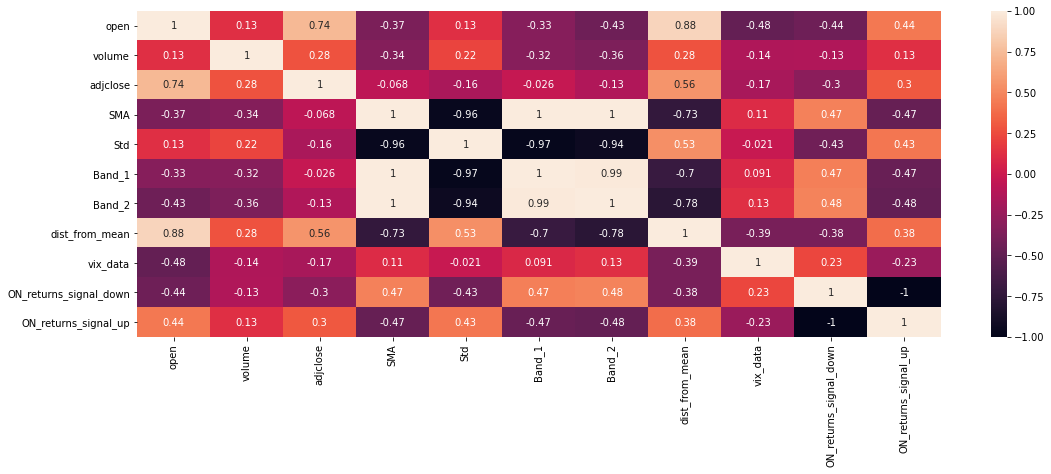

In [7]:
corr_table = features.drop(['high', 'low'], axis=1).corr()
fig, ax = plt.subplots(figsize=(18,6))
sn.heatmap(corr_table, annot = True, ax=ax)
plt.show()

In [8]:
X = features.drop(['stock_move','high', 'low'], axis=1)
y = features['stock_move']

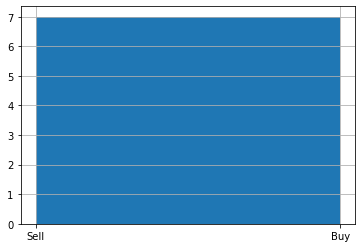

In [9]:
y.hist(bins=2);

In [10]:
#test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
#Scale the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
ticker_v = ['PLTR']
start_date_v = '2020-09-30'
end_date_v = '2021-01-15'
clf = svm.SVC(kernel = 'rbf')
df_v, ticker_not_found = get_stock_data(ticker_v, start_date, end_date)
features_v = get_clean_data(df_v, start_date_v, end_date_v)
X_val = features_v.drop(['stock_move','high', 'low'], axis=1)

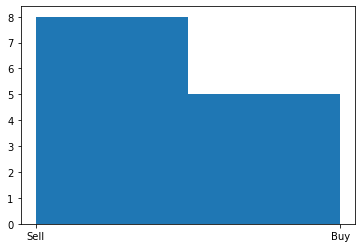

In [13]:
y_val = features_v['stock_move']
X_val = scaler.transform(X_val)
clf.fit(X_val, y_val)
y_pred_v = clf.predict(X_val)
plt.hist(y_pred_v, bins=2);

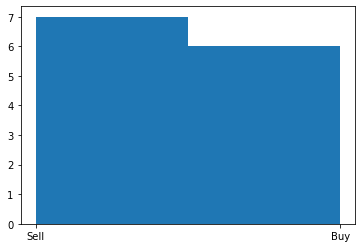

In [14]:
plt.hist(y_val, bins=2);

In [15]:
print ("Accuracy score of the model is: ", accuracy_score(y_val, y_pred_v))

Accuracy score of the model is:  0.7692307692307693


In [16]:
pred_df = pd.DataFrame() 

In [17]:
pred_df['Actual Data'] = y_val
pred_df['Predict Data'] = y_pred_v

In [18]:
pred_df.tail()

,Actual Data,Predict Data
68,Buy,Buy
69,Buy,Buy
70,Buy,Sell
71,Sell,Sell
72,Sell,Sell
